# Main Test Notebook

This notebook contains the main testing procedures of the project.

In [1]:
%load_ext autoreload
%autoreload 2

import time

import pandas as pd
import numpy as np
from descriptor_utils import DescriptorWrapper
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import samp as smp
import networkx as nx

In [2]:
# def load_mesh_and_sample_points(file_name, num_points=5000):
#     # Default number of points as indicated in the thesis
#     mesh = o3d.io.read_triangle_mesh(file_name)
#     point_cloud = mesh.sample_points_poisson_disk(num_points)
#     return np.asarray(point_cloud.points)

In [3]:
# path = 'mesh_files'
# 
# mesh_objects = []
# for idx, file in enumerate(os.listdir(path)):
#     print(f"Processing object {idx + 1} of {len(os.listdir(path))}: {file}")
#     file_path = os.path.join(path, file)
#     if os.path.isfile(file_path):
#         object_category = ''
#         if 'airplane' in file:
#             object_category = 'airplane'
#         elif 'dino' in file:
#             object_category = 'dinosaur'
#         else: 
#             object_category = 'fish'
#         mesh_objects.append([load_mesh_and_sample_points(file_path), object_category])

In [4]:
# Quick save since creating point clouds takes an eternity
# objects = [obj[0] for obj in mesh_objects]
# classes = [obj[1] for obj in mesh_objects]
# 
# np.savez('point_clouds.npz', objects=objects, classes=classes)

In [5]:
load_data = np.load('point_clouds.npz', allow_pickle=True)
point_clouds = [(pc, cat) for pc, cat in zip(load_data['objects'], load_data['classes'])]

In [6]:
# # Reload
# # point_clouds = [(pc, cat) for pc, cat in zip(load_data['objects'], load_data['classes'])]
# data_object = {
#     'dataset_name': 'McGill',
#     'point_clouds': load_data['objects'],
#     'labels': load_data['classes'],
# }
# 
# views = Views(data_object)
# views.generate_all_descriptors()

In [7]:
descriptor_wrapper = DescriptorWrapper()

# For each object, compute all possible descriptors and 
def process_descriptors(obj_list, class_list):
    data = {
        'object_index': [],
        'class': [],
        'evrap_x': [],
        'evrap_y': [],
        'evrap_z': [],
        'runtime_evrap': [],
        'samp_x': [],
        'samp_y': [],
        'runtime_samp': [],
        'sirm': [],
        'runtime_sirm': [],
        'scomp': [],
        'runtime_scomp': []
    }

    for index, obj in enumerate(obj_list):
        data['object_index'].append(index)
        data['class'].append(class_list[index])

        # Measure runtime for descriptor 'evrap'
        start_time = time.perf_counter()
        evrap = descriptor_wrapper.compute_evrap(obj)
        data['runtime_evrap'].append(time.perf_counter() - start_time)
        data['evrap_x'].append(evrap[0])
        data['evrap_y'].append(evrap[1])
        data['evrap_z'].append(evrap[2])

        # Measure runtime for descriptor 'samp'
        start_time = time.perf_counter()
        samp = descriptor_wrapper.compute_samp(obj)
        data['runtime_samp'].append(time.perf_counter() - start_time)
        data['samp_x'].append(samp[0])
        data['samp_y'].append(samp[1])

        start_time = time.perf_counter()
        data['sirm'].append(descriptor_wrapper.sirm(obj))
        data['runtime_sirm'].append(time.perf_counter() - start_time)

        # Measure runtime for descriptor 'scomp'
        start_time = time.perf_counter()
        data['scomp'].append(descriptor_wrapper.compute_scomp(obj))
        data['runtime_scomp'].append(time.perf_counter() - start_time)

    varimax_projections_1st_2nd_component = smp.varimax_projections_real_2d(obj_list)
    asymmetry_values_x_axis, _ = smp.asymmetries_x_axis(varimax_projections_1st_2nd_component)
    asymmetry_values_y_axis, _ = smp.asymmetries_y_axis(varimax_projections_1st_2nd_component)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_asymmetry_values_x_axis_norm = np.array(scaler.fit_transform(np.array(asymmetry_values_x_axis).reshape(-1, 1)))

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_asymmetry_values_y_axis_norm = np.array(scaler.fit_transform(np.array(asymmetry_values_y_axis).reshape(-1, 1)))

    min_max_asym_scaled = np.array(smp.min_max_asymmetries(scaled_asymmetry_values_x_axis_norm, scaled_asymmetry_values_y_axis_norm))
        
    # Standardize the values in samp
    data = pd.DataFrame(data)
    data['samp_x'] = min_max_asym_scaled[:,0]
    data['samp_y'] = min_max_asym_scaled[:,1]

    return data

In [8]:
point_cloud_df = process_descriptors([obj[0] for obj in point_clouds], [obj[1] for obj in point_clouds])

/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/nico/miniconda3/envs/p1-repository/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nico/miniconda3/envs/p1-repository/lib/py

In [9]:
def create_scatterplot_3d(data, descriptor):
    figure = plt.figure(figsize=(5, 5))
    ax = figure.add_subplot(111, projection='3d')

    # Map classes to colors
    unique_classes = data['class'].unique()
    colors = plt.cm.tab10(range(len(unique_classes))) 
    class_color_map = dict(zip(unique_classes, colors))
    
    # Plot points by class
    for class_label in unique_classes:
        class_data = data[data['class'] == class_label] 
        ax.scatter(
            class_data['evrap_x'], class_data['evrap_y'], class_data['evrap_z'],
            color=class_color_map[class_label], label=class_label, s=50
        )
        
    ax.legend()
    ax.set_title(descriptor)

def create_scatterplot_2d(data, descriptor):
    figure = plt.figure(figsize=(5, 5))
    ax = figure.add_subplot(111)
    
    # Map classes to colors
    unique_classes = data['class'].unique()
    colors = plt.cm.tab10(range(len(unique_classes)))
    class_color_map = dict(zip(unique_classes, colors))

    # Plot points by class
    for class_label in unique_classes:
        class_data = data[data['class'] == class_label]
        ax.scatter(
            class_data['samp_x'], class_data['samp_y'],
            color=class_color_map[class_label], label=class_label, s=50
        )

    ax.legend()
    ax.set_title(descriptor)

def create_scatterplot_1d(data, descriptor):
    figure = plt.figure(figsize=(5, 5))
    ax = figure.add_subplot(111)

    # Map classes to colors
    unique_classes = data['class'].unique()
    colors = plt.cm.tab10(range(len(unique_classes)))
    class_color_map = dict(zip(unique_classes, colors))

    # Plot points by class
    for class_label in unique_classes:
        class_data = data[data['class'] == class_label]
        x = np.arange(len(class_data[descriptor]))
        ax.scatter(
            x, class_data[descriptor], color=class_color_map[class_label], label=class_label,
        )

    ax.legend()
    ax.set_title(descriptor)

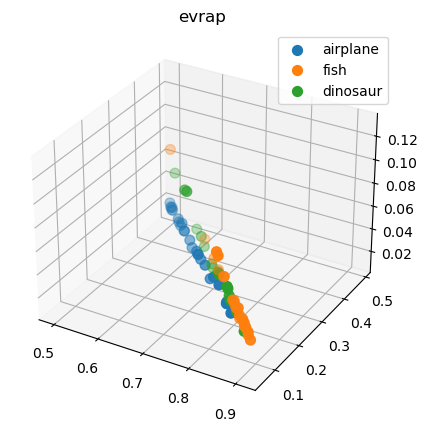

In [10]:
create_scatterplot_3d(point_cloud_df, 'evrap')

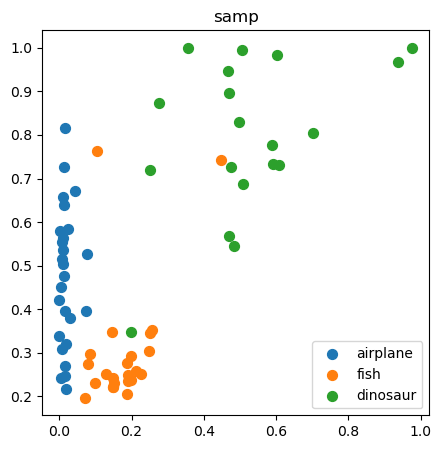

In [11]:
create_scatterplot_2d(point_cloud_df, 'samp')

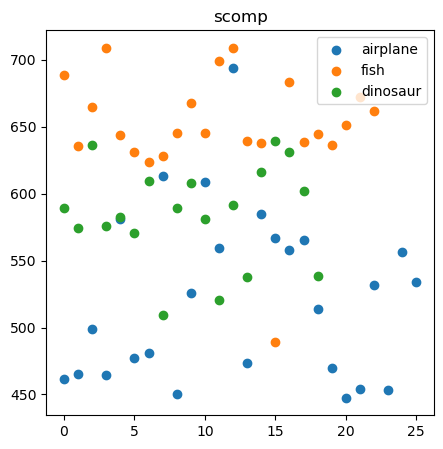

In [12]:
create_scatterplot_1d(point_cloud_df, 'scomp')

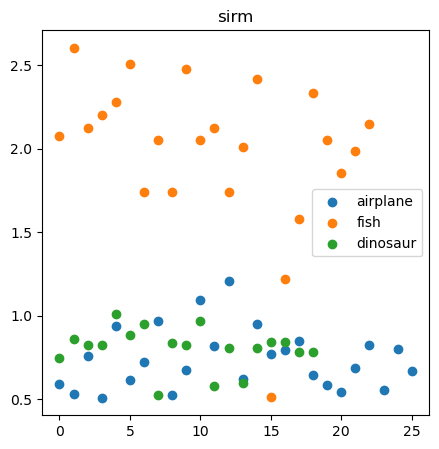

In [13]:
create_scatterplot_1d(point_cloud_df, 'sirm')

In [14]:
def compute_knn(data, descriptor_list=None, variant='directed', mode='connectivity', n_neighbors=5):
    """
    Works as a wrapper for creating k-NN graphs based on the requirement that graph properties can be changeable.
    The function can return directed, symmetric and mutual graphs, as well as directed and undirected ones. The default number
    of neighbors was chosen arbitrarily.

    :param data: Pandas Dataframe
        A dataframe containing the objects the k-NN graphs should be calculated on.
    :param descriptor_list: List of Strings
        A list used to specify which descriptors should be used to calculate the k-NN graph. The list should contain
        'sirm', 'scomp', 'evrap' or 'samp'.
    :param variant: {'directed', 'symmetric', 'mutual'}, default: 'directed'
        Used to specify what type of k-NN graph should be created. Mutual k-NN graphs only contain an edge, if both A is a neighbor of B and B is a neighbor of A, the lower distance is inserted into the graph in this implementation. A symmetric k-NN graph represents a logical or: If A is a neighbor of B or B is a neighbor of A, then B is a neighbor of A and A is a neighbor of B. In this implementation, for a weighted graph, the larger distance is used. A directed graph means that A can be a neighbor of B, even if B is not a neighbor of A.
    :param mode: {'connectivity', 'distance'}, default: 'connectivity'
        Choose if the k-NN graph is weighted or unweighted. 'connectivity' means the graph is unweighted, whereas 'distance' means the graph is weighted.
    :param n_neighbors: int, default: 5
        Specify how many nearest neighbors per object should be in the k-NN graph.
    :return: ndarray
        A k-NN graph.
    """
    if descriptor_list is None:
        descriptor_list = ['evrap']
        
    columns = []
    if 'evrap' in descriptor_list:
        columns.extend(['evrap_x', 'evrap_y', 'evrap_z'])
    if 'samp' in descriptor_list:
        columns.extend(['samp_x', 'samp_y'])
    if 'sirm' in descriptor_list:
        columns.extend(['sirm'])
    if 'scomp' in descriptor_list:
        columns.extend(['scomp'])

    # Graph is a matrix with entry A[i, j] if j is in the k-NN graph of i
    graph = kneighbors_graph(data[columns], mode=mode, n_neighbors=n_neighbors, n_jobs=-1)
    graph = graph.toarray()
    
    # the standard output of kneighbors_graph is a directed k-NN graph
    if variant == 'symmetric':
        graph = np.maximum(graph, graph.T).astype(int)
    elif variant == 'mutual':
        graph = np.minimum(graph, graph.T).astype(int)
        
    return graph

In [15]:
from scipy.sparse.csgraph import laplacian
from sklearn.cluster import KMeans

def compute_ratio_cut(adj_list, clusters):# Compute the Laplacian matrix of the graph
    unique_labels = np.unique(clusters)
    
    # Compute ratio cut value
    ratio_cut_value = 0
    for label in unique_labels:
        # Find nodes in the current cluster
        cluster_nodes = np.where(clusters == label)[0]
        cluster_size = len(cluster_nodes)

        # Find nodes not in the current cluster
        complement_nodes = np.setdiff1d(np.arange(len(clusters)), cluster_nodes)

        cut_value = adj_list[np.ix_(cluster_nodes, complement_nodes)].sum()

        # Add normalized cut to the total
        ratio_cut_value += cut_value / cluster_size

    return ratio_cut_value

def compute_normalized_cut(adj_matrix, labels):
    # Convert labels to clusters
    unique_labels = np.unique(labels)
    normalized_cut_value = 0

    for label in unique_labels:
        # Find nodes in the current cluster
        cluster_nodes = np.where(labels == label)[0]

        # Find nodes not in the current cluster
        complement_nodes = np.setdiff1d(np.arange(len(labels)), cluster_nodes)

        # Compute Cut(V_i, complement)
        cut_value = adj_matrix[np.ix_(cluster_nodes, complement_nodes)].sum()

        # Compute Vol(V_i)
        vol_value = adj_matrix[cluster_nodes, :].sum()

        # Add normalized cut value
        if vol_value > 0:  # Avoid division by zero
            normalized_cut_value += cut_value / vol_value

    return normalized_cut_value

In [16]:
# example: knn_graph = compute_knn(point_cloud_df, ['scomp'])

In [17]:
def plot_evaluation(ax, descriptor_list, cut_results, y_label, title):
    # Plotting
    for descriptor in descriptor_list:
        ax.plot(k_values, cut_results[descriptor], label=f"{descriptor}")
    
    ax.set_xlabel("k (Number of Neighbors)", color='white')
    ax.set_ylabel(y_label, color='white')
    ax.set_title(y_label + " Across Descriptors, " + title, color='white')
    ax.legend()
    ax.grid(True)
    
    ax.set_facecolor('#333333')  # Dark grey background for the plot area
    
    # Customize ticks and labels
    ax.tick_params(colors='white')  # White ticks
    ax.xaxis.label.set_color('white')  # X-axis label color
    ax.yaxis.label.set_color('white')  # Y-axis label color
    
    
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')
    
    ax.set_xlim(2, 25)
    
    # Customize grid
    ax.grid(color='#666666', linestyle='--', linewidth=0.7)

## Plots k-NN graphs

In [18]:
def compute_spectral_clustering(adj_matrix, cluster_count):
    # Compute the Laplacian matrix of the graph
    l, degree = laplacian(adj_matrix, normed=False, return_diag=True)

    # Perform eigen decomposition to find the smallest eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(l)

    # Select the smallest `num_clusters` eigenvectors (excluding the first, which is trivial)
    smallest_eigenvectors = eigenvectors[:, 1:cluster_count]

    # Cluster the nodes using k-means on the selected eigenvectors
    kmeans = KMeans(n_clusters=cluster_count, random_state=0, n_init=10)
    return kmeans.fit_predict(smallest_eigenvectors)

In [19]:
descriptors = ['evrap', 'samp', 'sirm', 'scomp']
k_values = range(2, 26)

In [20]:
symmetric_ratio_cut_results = {
    'true': {descriptor: [] for descriptor in descriptors},
    'predicted': {descriptor: [] for descriptor in descriptors}
}
symmetric_normalized_cut_results = {
    'true': {descriptor: [] for descriptor in descriptors},
    'predicted': {descriptor: [] for descriptor in descriptors}
}
for k in k_values:
    for descriptor in descriptors:
        knn_graph = compute_knn(point_cloud_df, descriptor_list=[descriptor], n_neighbors=k, variant='symmetric')
        cluster_labels = point_cloud_df['class']
        n_clusters = len(np.unique(cluster_labels))
        predicted_labels = compute_spectral_clustering(knn_graph, n_clusters)

        ratio_cut = compute_ratio_cut(knn_graph, cluster_labels)
        normalized_cut = compute_normalized_cut(knn_graph, cluster_labels)
        
        symmetric_ratio_cut_results['true'][descriptor].append(ratio_cut)
        symmetric_normalized_cut_results['true'][descriptor].append(normalized_cut)

        ratio_cut = compute_ratio_cut(knn_graph, predicted_labels)
        normalized_cut = compute_normalized_cut(knn_graph, predicted_labels)
        
        symmetric_ratio_cut_results['predicted'][descriptor].append(ratio_cut)
        symmetric_normalized_cut_results['predicted'][descriptor].append(normalized_cut)

In [21]:
mutual_ratio_cut_results = {
    'true': {descriptor: [] for descriptor in descriptors},
    'predicted': {descriptor: [] for descriptor in descriptors}
}
mutual_normalized_cut_results = {
    'true': {descriptor: [] for descriptor in descriptors},
    'predicted': {descriptor: [] for descriptor in descriptors}
}
for k in k_values:
    for descriptor in descriptors:
        knn_graph = compute_knn(point_cloud_df, descriptor_list=[descriptor], n_neighbors=k, variant='mutual')
        cluster_labels = point_cloud_df['class']
        n_clusters = len(np.unique(cluster_labels))
        predicted_labels = compute_spectral_clustering(knn_graph, n_clusters)
        
        ratio_cut = compute_ratio_cut(knn_graph, cluster_labels)
        normalized_cut = compute_normalized_cut(knn_graph, cluster_labels)
        
        mutual_ratio_cut_results['true'][descriptor].append(ratio_cut)
        mutual_normalized_cut_results['true'][descriptor].append(normalized_cut)

        ratio_cut = compute_ratio_cut(knn_graph, predicted_labels)
        normalized_cut = compute_normalized_cut(knn_graph, predicted_labels)

        mutual_ratio_cut_results['predicted'][descriptor].append(ratio_cut)
        mutual_normalized_cut_results['predicted'][descriptor].append(normalized_cut)

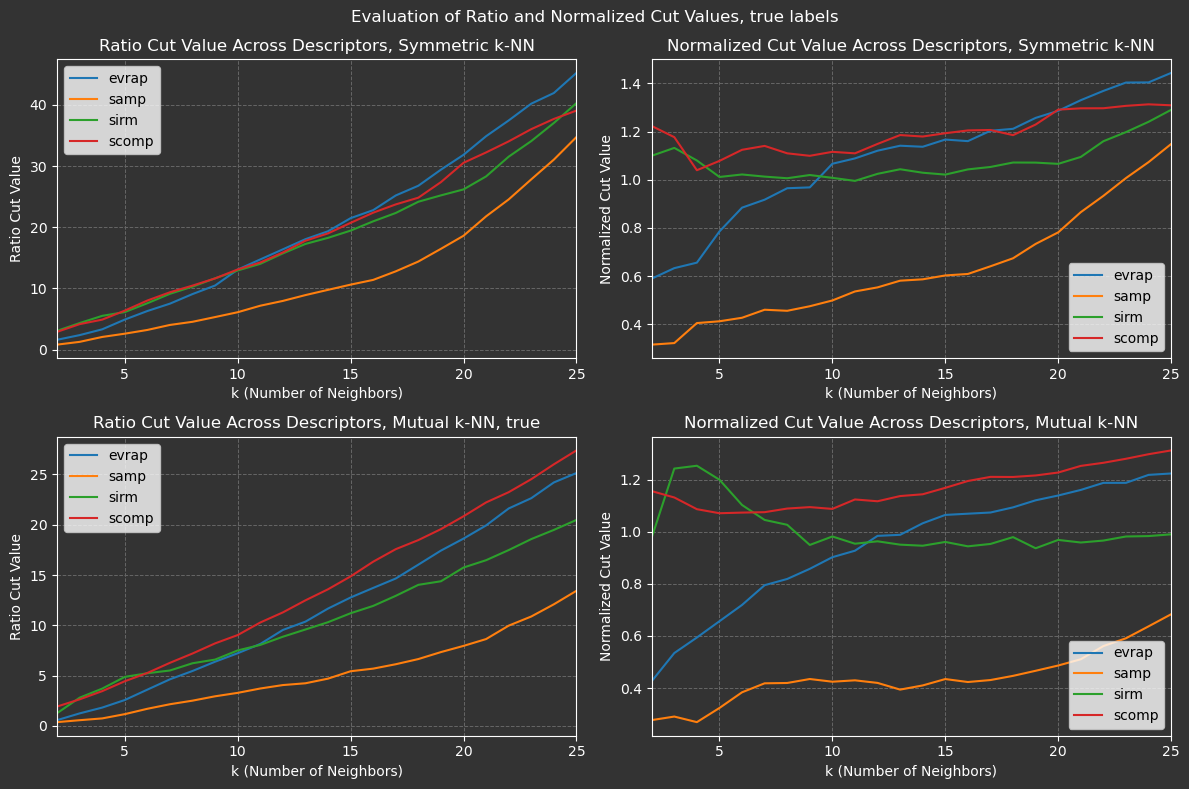

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Example with a 2x2 grid of subplots

plot_evaluation(axes[0][0], descriptors, symmetric_ratio_cut_results['true'], y_label='Ratio Cut Value', title="Symmetric k-NN")
plot_evaluation(axes[0][1], descriptors, symmetric_normalized_cut_results['true'], y_label='Normalized Cut Value', title="Symmetric k-NN")
plot_evaluation(axes[1][0], descriptors, mutual_ratio_cut_results['true'], y_label='Ratio Cut Value', title="Mutual k-NN, true")
plot_evaluation(axes[1][1], descriptors, mutual_normalized_cut_results['true'], y_label='Normalized Cut Value', title="Mutual k-NN")

fig.suptitle("Evaluation of Ratio and Normalized Cut Values, true labels", color="white")

# Set figure background and adjust layout
fig.patch.set_facecolor('#333333')  # Dark grey background for the figure
fig.tight_layout()  # Ensure subplots fit within the figure

plt.show()

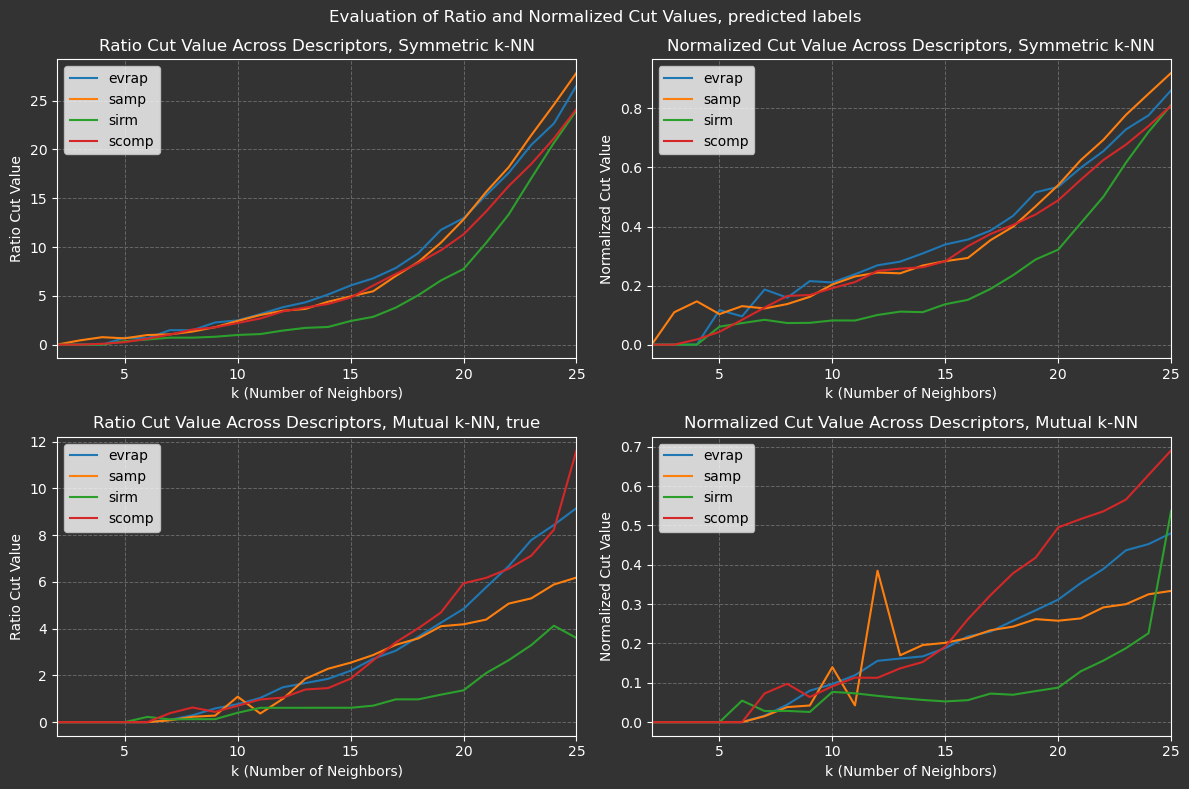

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Example with a 2x2 grid of subplots

plot_evaluation(axes[0][0], descriptors, symmetric_ratio_cut_results['predicted'], y_label='Ratio Cut Value', title="Symmetric k-NN")
plot_evaluation(axes[0][1], descriptors, symmetric_normalized_cut_results['predicted'], y_label='Normalized Cut Value', title="Symmetric k-NN")
plot_evaluation(axes[1][0], descriptors, mutual_ratio_cut_results['predicted'], y_label='Ratio Cut Value', title="Mutual k-NN, true")
plot_evaluation(axes[1][1], descriptors, mutual_normalized_cut_results['predicted'], y_label='Normalized Cut Value', title="Mutual k-NN")

fig.suptitle("Evaluation of Ratio and Normalized Cut Values, predicted labels", color="white")

# Set figure background and adjust layout
fig.patch.set_facecolor('#333333')  # Dark grey background for the figure
fig.tight_layout()  # Ensure subplots fit within the figure

plt.show()

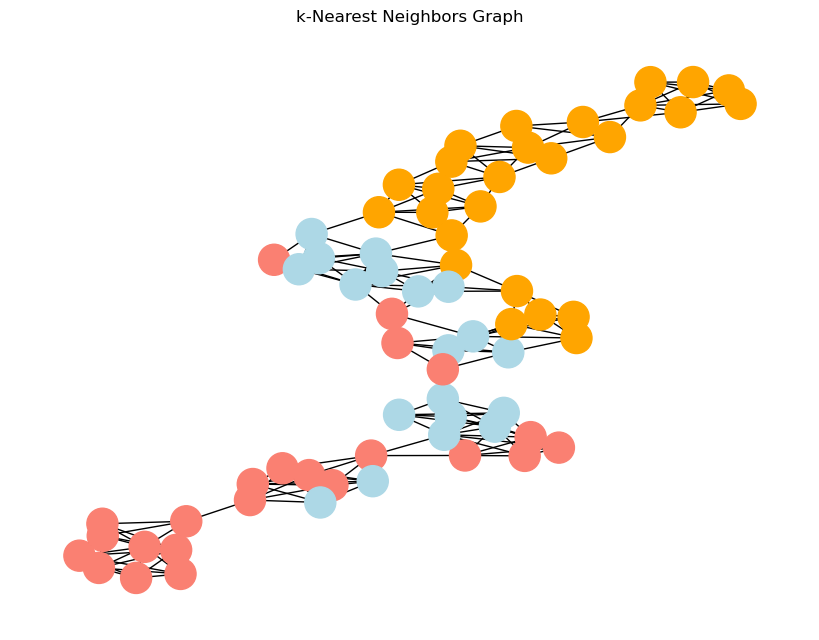

In [24]:
knn_graph = compute_knn(point_cloud_df, descriptor_list=['evrap'], n_neighbors=5, variant='symmetric')

G = nx.from_numpy_array(knn_graph)

label_color_map = {'dinosaur': 'lightblue', 'fish': 'salmon', 'airplane': 'orange'}
node_colors = [label_color_map[row[1]['class']] for row in point_cloud_df.iterrows()]

plt.figure(figsize=(8, 6))
pos = nx.kamada_kawai_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=False, node_size=500, node_color=node_colors, font_weight="bold")

plt.title("k-Nearest Neighbors Graph")
plt.show()

In [25]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(point_cloud_df[['evrap_x', 'evrap_y', 'evrap_z']], point_cloud_df['class'])

KNeighborsClassifier(n_neighbors=3)

In [26]:
neigh.predict(point_cloud_df.loc[[0]][['evrap_x', 'evrap_y', 'evrap_z']])

array(['airplane'], dtype=object)